In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision import models
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import time
import numpy as np
import shutil
import os
import argparse
from PIL import Image
import matplotlib.pyplot as plt
import glob
import os, random

In [2]:
m = nn.Softmax()

cfg = {
    'root': [16, 32, 32,'M'],
    '2': [16, 'M', 32, 'M', 'D'],
    '3': [32, 64, 'M', 'D'],
    '1': [32, 32, 'M', 'D'],
    '5': [16, 32, 'M', 32, 32, 'M', 64,'D'],
    '6': [16, 32, 32, 'M', 64, 64, 128, 'M', 'D'],
}

In [3]:
class model(nn.Module):
    def __init__(self, size):
        super(model, self).__init__()
        self.features = self._make_layers(cfg[size])
        self.classifier = nn.Sequential(
                        nn.Linear(32*16*16, 6),
                )

    def forward(self, x):
        y = self.features(x)
        x = y.view(y.size(0), -1)
        out = self.classifier(x)
        return y,out

    def _make_layers(self, cfg, channels = 3):
        layers = []
        in_channels = channels
        for x in cfg:
            if x == 'D':
                layers += [nn.Dropout()]
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1), nn.BatchNorm2d(x), nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

def model_root():
    return model('root')

class mod_one(nn.Module):
    def __init__(self, size):
        super(mod_one, self).__init__()
        self.features = self._make_layers(cfg[size], 32)
        self.classifier = nn.Sequential(
                        nn.Linear(32*8*8, 2),
                )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        out = self.classifier(x)
        return x,out

    def _make_layers(self, cfg, channels = 3):
        layers = []
        in_channels = channels
        for x in cfg:
            if x == 'D':
                layers += [nn.Dropout()]
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1), nn.BatchNorm2d(x), nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

def model_1():
    return mod_one('1')

class mod_three(nn.Module):
    def __init__(self, size):
        super(mod_three, self).__init__()
        self.features = self._make_layers(cfg[size], 32)
        self.classifier = nn.Sequential(
                        nn.Linear(64*8*8, 4),
                )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        out = self.classifier(x)
        return x,out

    def _make_layers(self, cfg, channels = 3):
        layers = []
        in_channels = channels
        for x in cfg:
            if x == 'D':
                layers += [nn.Dropout()]
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1), nn.BatchNorm2d(x), nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

def model_3():
    return mod_three('3')

In [4]:
leaves = {"root": [0,2,4,9], "root_3":[0,1,2,3], "root_1": [0,1]}
mapper = {"root": {0:0,2:2,4:4,9:9}, "root_3":{0:3,1:5,2:8,3:6}, "root_1": {0:1,1:7}}
def is_leaf(path, output):
    if output in leaves[path]:
        return True
    return False

def find_category(path, leaf):
    return mapper[path][leaf]

In [5]:
models = {"root_3": model_3(), "root_1": model_1()}
model_name = {"root_3": "../Models/svhn_3.pth", "root_1": "../Models/svhn_1.pth"}

def fetch_model(path):
    model = models[path].cuda().eval()
    model.load_state_dict(torch.load(model_name[path]))
    return model
    

In [6]:
def demo(model, img, device):
    parent = "root"
    path = "root"
    next_data, root_out = model(img.view(1,img.shape[0], img.shape[1], img.shape[2]))
    root_out = root_out.max(1, keepdim=True)[1]
    if is_leaf(path, root_out.item()):
            return find_category(path, root_out.item())
    parent = str(root_out.item())
    
    while(1): 
        path = path + "_" + parent
        model = fetch_model(path)
        model = model.eval()
        next_data, model_out = model(next_data)
        model_out = model_out.max(1, keepdim=True)[1]
        if is_leaf(path, model_out.item()):
            return find_category(path, model_out.item())
        parent = str(model_out.item())

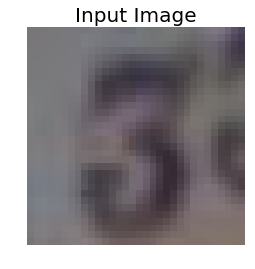

Prediction:  3


In [13]:
def main():
    img_path = glob.glob('img/svhn/*.jpg')[random.randint(1,len(glob.glob('img/svhn/*.jpg'))-1)]
    img = Image.open(img_path)
    plt.imshow(np.asarray(img))
    plt.axis('off')
    plt.title("Input Image", fontsize = 20)
    plt.show()
    img = transforms.ToTensor()(img).cuda()
    model = model_root().cuda().eval()
    model.load_state_dict(torch.load('../Models/svhn_root.pth'))
    print("Prediction: ", demo(model, img, torch.device("cuda")))

if __name__== "__main__":
        main()
